In [1]:
#!pip install compiler_gym 'ray[default,rllib]' &>/dev/null || echo "Install failed!"

import compiler_gym
import ray

from ray.rllib.agents.ppo import PPOTrainer
from compiler_gym.wrappers import ConstrainedCommandline, TimeLimit
from ray import tune
from itertools import islice
from compiler_gym.wrappers import CycleOverBenchmarks
from compiler_gym.util.registration import register

import loop_tool_service

from service_py.datasets import loop_tool_dataset
from service_py.rewards import flops_loop_nest_reward, flops_reward, runtime_reward

In [2]:
def make_env() -> compiler_gym.envs.CompilerEnv:
    """Make the reinforcement learning environment for this experiment."""
    
    env = loop_tool_service.make(
        "loop_tool_env-v0",
        observation_space="ir_tensor",
        reward_space="flops_loop_nest",
        # reward_space="runtime",
    )

    env = TimeLimit(env, max_episode_steps=10)
    return env

In [3]:
with make_env() as env:
    print("Action space:", env.action_space)
    print("Observation space:", env.observation_space)
    print("Reward space:", env.reward_space)

Action space: NamedDiscrete([up, down, swap_up, swap_down])
Observation space: Box([[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False Fal

In [4]:
with make_env() as env:
    # The two datasets we will be using:
    lt_dataset = env.datasets["loop_tool_simple-v0"]
    # train_benchmarks = list(islice(lt_dataset.benchmarks(), 1))
    # test_benchmarks = list(islice(lt_dataset.benchmarks(), 2))
    
    bench = ["benchmark://loop_tool_simple-v0/simple",
             "benchmark://loop_tool_simple-v0/mm128", 
             "benchmark://loop_tool_simple-v0/mm"] 
    train_benchmarks = bench
    test_benchmarks = bench

print("Number of benchmarks for training:", len(train_benchmarks))
print("Number of benchmarks for testing:", len(test_benchmarks))


Number of benchmarks for training: 3
Number of benchmarks for testing: 3


In [5]:
def make_training_env(*args) -> compiler_gym.envs.CompilerEnv:
    """Make a reinforcement learning environment that cycles over the
    set of training benchmarks in use.
    """
    del args  # Unused env_config argument passed by ray
    return CycleOverBenchmarks(make_env(), train_benchmarks)


In [6]:
with make_training_env() as env:
    env.reset()
    print(env.benchmark)
    env.reset()
    print(env.benchmark)

E0622 23:46:58.507242 140061358155328 example_service.py:212] CRITICAL - 

Working_dir = /dev/shm/compiler_gym_dejang/s/0622T234657-466934-4b9f

E0622 23:46:58.618221 140061358155328 example_service.py:212] CRITICAL - 

Working_dir = /dev/shm/compiler_gym_dejang/s/0622T234657-466934-4b9f



for m_5586 in 128 : L0  <<<<<< cursor (line 0 )
 for n_5625 in 128 : L1  
  for k_5587 in 128 : L2  
   %2[m_5586, k_5587, n_5625] <- multiply(%0, %1)  
   %3[m_5586, n_5625] <- add(%2)  
  %4[m_5586, n_5625] <- write(%3)  

benchmark://loop_tool_simple-v0/simple
for m_98 in 8 : L0  <<<<<< cursor (line 0 )
 for k_99 in 8 : L1  
  for m_98' in 16 : L2  
   for n_137 in 8 : L3  
    for k_99' in 16 : L4  
     for n_137' in 16 : L5  
      %2[m_98, k_99, n_137] <- multiply(%0, %1)  
      %3[m_98, n_137] <- add(%2)  
 for m_98' in 16 : L8  
  for n_137 in 128 : L9  
   %4[m_98, n_137] <- write(%3)  

benchmark://loop_tool_simple-v0/mm128


In [7]:
if ray.is_initialized():
    ray.shutdown()
ray.init(include_dashboard=False, ignore_reinit_error=True)

tune.register_env("compiler_gym", make_training_env)

In [8]:
analysis = tune.run(
    PPOTrainer,
    # fail_fast="raise",
    checkpoint_at_end=True,
    stop={
        "episodes_total": 5,
    },
    config={
        "seed": 0xCC,
        "num_workers": 1,
        # Specify the environment to use, where "compiler_gym" is the name we
        # passed to tune.register_env().
        "env": "compiler_gym",
        # Reduce the size of the batch/trajectory lengths to match our short
        # training run.
        # "framework":'tf2',
        # "disable_env_checking":True,
        "rollout_fragment_length": 5,
        "train_batch_size": 5,
        "sgd_minibatch_size": 5,
    }
)

(PPOTrainer pid=4083490) 2022-06-22 23:47:05,437	INFO trainer.py:2332 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
(PPOTrainer pid=4083490) 2022-06-22 23:47:05,780	INFO ppo.py:414 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(PPOTrainer pid=4083490) 2022-06-22 23:47:05,780	INFO trainer.py:903 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=4083548) E0622 23:47:11.036283 140038764869184 example_service.py:212] CRITICAL - 
(RolloutWorker pid=4083548) 
(RolloutWorker pid=4083548) Working_dir = /dev/shm/compiler_gym_dejang/s/0622T234710-009093-6f35
(RolloutWorker pid=4083548) 


(RolloutWorker pid=4083548) for m_5586 in 128 : L0  <<<<<< cursor (line 0 )
(RolloutWorker pid=4083548)  for n_5625 in 128 : L1  
(RolloutWorker pid=4083548)   for k_5587 in 128 : L2  
(RolloutWorker pid=4083548)    %2[m_5586, k_5587, n_5625] <- multiply(%0, %1)  
(RolloutWorker pid=4083548)    %3[m_5586, n_5625] <- add(%2)  
(RolloutWorker pid=4083548)   %4[m_5586, n_5625] <- write(%3)  
(RolloutWorker pid=4083548) 


(PPOTrainer pid=4083490) 2022-06-22 23:47:13,631	WARNING util.py:65 -- Install gputil for GPU system monitoring.


Trial name,status,loc
PPOTrainer_compiler_gym_23ab2_00000,RUNNING,100.37.253.28:4083490


(RolloutWorker pid=4083548) E0622 23:47:13.658684 140038764869184 example_service.py:212] CRITICAL - 
(RolloutWorker pid=4083548) 
(RolloutWorker pid=4083548) Working_dir = /dev/shm/compiler_gym_dejang/s/0622T234710-009093-6f35
(RolloutWorker pid=4083548) 


(RolloutWorker pid=4083548) for m_98 in 8 : L0  <<<<<< cursor (line 0 )
(RolloutWorker pid=4083548)  for k_99 in 8 : L1  
(RolloutWorker pid=4083548)   for m_98' in 16 : L2  
(RolloutWorker pid=4083548)    for n_137 in 8 : L3  
(RolloutWorker pid=4083548)     for k_99' in 16 : L4  
(RolloutWorker pid=4083548)      for n_137' in 16 : L5  
(RolloutWorker pid=4083548)       %2[m_98, k_99, n_137] <- multiply(%0, %1)  
(RolloutWorker pid=4083548)       %3[m_98, n_137] <- add(%2)  
(RolloutWorker pid=4083548)  for m_98' in 16 : L8  
(RolloutWorker pid=4083548)   for n_137 in 128 : L9  
(RolloutWorker pid=4083548)    %4[m_98, n_137] <- write(%3)  
(RolloutWorker pid=4083548) 
(RolloutWorker pid=4083548) Action = down
(RolloutWorker pid=4083548) for m_98 in 8 : L0  <<<<<< cursor (line 0 )
(RolloutWorker pid=4083548)  for k_99 in 8 : L1  
(RolloutWorker pid=4083548)   for m_98' in 16 : L2  
(RolloutWorker pid=4083548)    for n_137 in 8 : L3  
(RolloutWorker pid=4083548)     for k_99' in 16 : L4

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_compiler_gym_23ab2_00000,RUNNING,100.37.253.28:4083490,1,3.29693,5,nan,nan,nan,nan


(RolloutWorker pid=4083548) Action = down
(RolloutWorker pid=4083548) for m_98 in 8 : L0  <<<<<< cursor (line 0 )
(RolloutWorker pid=4083548)  for k_99 in 8 : L1  
(RolloutWorker pid=4083548)   for m_98' in 16 : L2  
(RolloutWorker pid=4083548)    for n_137 in 8 : L3  
(RolloutWorker pid=4083548)     for k_99' in 16 : L4  
(RolloutWorker pid=4083548)      for n_137' in 16 : L5  
(RolloutWorker pid=4083548)       %2[m_98, k_99, n_137] <- multiply(%0, %1)  
(RolloutWorker pid=4083548)       %3[m_98, n_137] <- add(%2)  
(RolloutWorker pid=4083548)  for m_98' in 16 : L8  
(RolloutWorker pid=4083548)   for n_137 in 128 : L9  
(RolloutWorker pid=4083548)    %4[m_98, n_137] <- write(%3)  
(RolloutWorker pid=4083548) 
(RolloutWorker pid=4083548) Action = down
(RolloutWorker pid=4083548) for m_98 in 8 : L0  
(RolloutWorker pid=4083548)  for k_99 in 8 : L1  <<<<<< cursor (line 1 )
(RolloutWorker pid=4083548)   for m_98' in 16 : L2  
(RolloutWorker pid=4083548)    for n_137 in 8 : L3  
(RolloutWo

(RolloutWorker pid=4083548) E0622 23:47:21.021296 140038764869184 example_service.py:212] CRITICAL - 
(RolloutWorker pid=4083548) 
(RolloutWorker pid=4083548) Working_dir = /dev/shm/compiler_gym_dejang/s/0622T234710-009093-6f35
(RolloutWorker pid=4083548) 


(RolloutWorker pid=4083548) Action = swap_up
(RolloutWorker pid=4083548) for m_98 in 8 : L0  
(RolloutWorker pid=4083548)  for k_99 in 8 : L1  
(RolloutWorker pid=4083548)   for n_137 in 8 : L2  
(RolloutWorker pid=4083548)    for m_98' in 16 : L3  
(RolloutWorker pid=4083548)     for k_99' in 16 : L4  <<<<<< cursor (line 4 )
(RolloutWorker pid=4083548)      for n_137' in 16 : L5  
(RolloutWorker pid=4083548)       %2[m_98, k_99, n_137] <- multiply(%0, %1)  
(RolloutWorker pid=4083548)       %3[m_98, n_137] <- add(%2)  
(RolloutWorker pid=4083548)  for m_98' in 16 : L8  
(RolloutWorker pid=4083548)   for n_137 in 128 : L9  
(RolloutWorker pid=4083548)    %4[m_98, n_137] <- write(%3)  
(RolloutWorker pid=4083548) 
(RolloutWorker pid=4083548) for m_98 in 128 : L0  <<<<<< cursor (line 0 )
(RolloutWorker pid=4083548)  for k_99 in 128 : L1  
(RolloutWorker pid=4083548)   for n_137 in 128 : L2  
(RolloutWorker pid=4083548)    %2[m_98, k_99, n_137] <- multiply(%0, %1)  
(RolloutWorker pid=408

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_compiler_gym_23ab2_00000,RUNNING,100.37.253.28:4083490,3,10.4113,15,-0.503626,-0.503626,-0.503626,10


(RolloutWorker pid=4083548) Action = down
(RolloutWorker pid=4083548) for n_137 in 128 : L0  <<<<<< cursor (line 0 )
(RolloutWorker pid=4083548)  for m_98 in 128 : L1  
(RolloutWorker pid=4083548)   for k_99 in 128 : L2  
(RolloutWorker pid=4083548)    %2[m_98, k_99, n_137] <- multiply(%0, %1)  
(RolloutWorker pid=4083548)    %3[m_98, n_137] <- add(%2)  
(RolloutWorker pid=4083548)   %4[m_98, n_137] <- write(%3)  
(RolloutWorker pid=4083548) 
(RolloutWorker pid=4083548) Action = swap_down
(RolloutWorker pid=4083548) for n_137 in 128 : L0  
(RolloutWorker pid=4083548)  for m_98 in 128 : L1  <<<<<< cursor (line 1 )
(RolloutWorker pid=4083548)   for k_99 in 128 : L2  
(RolloutWorker pid=4083548)    %2[m_98, k_99, n_137] <- multiply(%0, %1)  
(RolloutWorker pid=4083548)    %3[m_98, n_137] <- add(%2)  
(RolloutWorker pid=4083548)   %4[m_98, n_137] <- write(%3)  
(RolloutWorker pid=4083548) 
(RolloutWorker pid=4083548) Action = up
(RolloutWorker pid=4083548) for n_137 in 128 : L0  
(RolloutW

(RolloutWorker pid=4083548) E0622 23:47:27.525151 140038764869184 example_service.py:212] CRITICAL - 
(RolloutWorker pid=4083548) 
(RolloutWorker pid=4083548) Working_dir = /dev/shm/compiler_gym_dejang/s/0622T234710-009093-6f35
(RolloutWorker pid=4083548) 


(RolloutWorker pid=4083548) Action = up
(RolloutWorker pid=4083548) for n_137 in 128 : L0  
(RolloutWorker pid=4083548)  for k_99 in 128 : L1  <<<<<< cursor (line 1 )
(RolloutWorker pid=4083548)   for m_98 in 128 : L2  
(RolloutWorker pid=4083548)    %2[m_98, k_99, n_137] <- multiply(%0, %1)  
(RolloutWorker pid=4083548)    %3[m_98, n_137] <- add(%2)  
(RolloutWorker pid=4083548)  for m_98 in 128 : L5  
(RolloutWorker pid=4083548)   %4[m_98, n_137] <- write(%3)  
(RolloutWorker pid=4083548) 
(RolloutWorker pid=4083548) for m_5586 in 128 : L0  <<<<<< cursor (line 0 )
(RolloutWorker pid=4083548)  for n_5625 in 128 : L1  
(RolloutWorker pid=4083548)   for k_5587 in 128 : L2  
(RolloutWorker pid=4083548)    %2[m_5586, k_5587, n_5625] <- multiply(%0, %1)  
(RolloutWorker pid=4083548)    %3[m_5586, n_5625] <- add(%2)  
(RolloutWorker pid=4083548)   %4[m_5586, n_5625] <- write(%3)  
(RolloutWorker pid=4083548) 
(RolloutWorker pid=4083548) Action = swap_down
(RolloutWorker pid=4083548) for m_5

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_compiler_gym_23ab2_00000,RUNNING,100.37.253.28:4083490,5,17.4589,25,-1.05248,-0.503626,-1.60133,10


(RolloutWorker pid=4083548) Action = swap_down
(RolloutWorker pid=4083548) for m_5586 in 128 : L0  
(RolloutWorker pid=4083548)  for n_5625 in 128 : L1  <<<<<< cursor (line 1 )
(RolloutWorker pid=4083548)   for k_5587 in 128 : L2  
(RolloutWorker pid=4083548)    %2[m_5586, k_5587, n_5625] <- multiply(%0, %1)  
(RolloutWorker pid=4083548)    %3[m_5586, n_5625] <- add(%2)  
(RolloutWorker pid=4083548)   %4[m_5586, n_5625] <- write(%3)  
(RolloutWorker pid=4083548) 
(RolloutWorker pid=4083548) Action = up
(RolloutWorker pid=4083548) for m_5586 in 128 : L0  
(RolloutWorker pid=4083548)  for k_5587 in 128 : L1  
(RolloutWorker pid=4083548)   for n_5625 in 128 : L2  <<<<<< cursor (line 2 )
(RolloutWorker pid=4083548)    %2[m_5586, k_5587, n_5625] <- multiply(%0, %1)  
(RolloutWorker pid=4083548)    %3[m_5586, n_5625] <- add(%2)  
(RolloutWorker pid=4083548)  for n_5625 in 128 : L5  
(RolloutWorker pid=4083548)   %4[m_5586, n_5625] <- write(%3)  
(RolloutWorker pid=4083548) 
(RolloutWorker pi

(RolloutWorker pid=4083548) E0622 23:47:34.369704 140038764869184 example_service.py:212] CRITICAL - 
(RolloutWorker pid=4083548) 
(RolloutWorker pid=4083548) Working_dir = /dev/shm/compiler_gym_dejang/s/0622T234710-009093-6f35
(RolloutWorker pid=4083548) 


(RolloutWorker pid=4083548) Action = down
(RolloutWorker pid=4083548) for m_98 in 8 : L0  <<<<<< cursor (line 0 )
(RolloutWorker pid=4083548)  for k_99 in 8 : L1  
(RolloutWorker pid=4083548)   for m_98' in 16 : L2  
(RolloutWorker pid=4083548)    for n_137 in 8 : L3  
(RolloutWorker pid=4083548)     for k_99' in 16 : L4  
(RolloutWorker pid=4083548)      for n_137' in 16 : L5  
(RolloutWorker pid=4083548)       %2[m_98, k_99, n_137] <- multiply(%0, %1)  
(RolloutWorker pid=4083548)       %3[m_98, n_137] <- add(%2)  
(RolloutWorker pid=4083548)  for m_98' in 16 : L8  
(RolloutWorker pid=4083548)   for n_137 in 128 : L9  
(RolloutWorker pid=4083548)    %4[m_98, n_137] <- write(%3)  
(RolloutWorker pid=4083548) 
(RolloutWorker pid=4083548) Action = swap_up
(RolloutWorker pid=4083548) for m_98 in 8 : L0  
(RolloutWorker pid=4083548)  for k_99 in 8 : L1  <<<<<< cursor (line 1 )
(RolloutWorker pid=4083548)   for m_98' in 16 : L2  
(RolloutWorker pid=4083548)    for n_137 in 8 : L3  
(Rollou

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_compiler_gym_23ab2_00000,RUNNING,100.37.253.28:4083490,7,23.7309,35,3.45613,12.4734,-1.60133,10


(RolloutWorker pid=4083548) Action = down
(RolloutWorker pid=4083548) for k_99 in 8 : L0  <<<<<< cursor (line 0 )
(RolloutWorker pid=4083548)  for m_98 in 8 : L1  
(RolloutWorker pid=4083548)   for m_98' in 16 : L2  
(RolloutWorker pid=4083548)    for n_137 in 8 : L3  
(RolloutWorker pid=4083548)     for k_99' in 16 : L4  
(RolloutWorker pid=4083548)      for n_137' in 16 : L5  
(RolloutWorker pid=4083548)       %2[m_98, k_99, n_137] <- multiply(%0, %1)  
(RolloutWorker pid=4083548)       %3[m_98, n_137] <- add(%2)  
(RolloutWorker pid=4083548) for m_98 in 8 : L8  
(RolloutWorker pid=4083548)  for m_98' in 16 : L9  
(RolloutWorker pid=4083548)   for n_137 in 128 : L10  
(RolloutWorker pid=4083548)    %4[m_98, n_137] <- write(%3)  
(RolloutWorker pid=4083548) 
(RolloutWorker pid=4083548) Action = swap_up
(RolloutWorker pid=4083548) for k_99 in 8 : L0  
(RolloutWorker pid=4083548)  for m_98 in 8 : L1  <<<<<< cursor (line 1 )
(RolloutWorker pid=4083548)   for m_98' in 16 : L2  
(RolloutWo

(RolloutWorker pid=4083548) E0622 23:47:40.949033 140038764869184 example_service.py:212] CRITICAL - 
(RolloutWorker pid=4083548) 
(RolloutWorker pid=4083548) Working_dir = /dev/shm/compiler_gym_dejang/s/0622T234710-009093-6f35
(RolloutWorker pid=4083548) 


(RolloutWorker pid=4083548) Action = up
(RolloutWorker pid=4083548) for m_98 in 8 : L0  
(RolloutWorker pid=4083548)  for k_99 in 8 : L1  <<<<<< cursor (line 1 )
(RolloutWorker pid=4083548)   for m_98' in 16 : L2  
(RolloutWorker pid=4083548)    for n_137 in 8 : L3  
(RolloutWorker pid=4083548)     for k_99' in 16 : L4  
(RolloutWorker pid=4083548)      for n_137' in 16 : L5  
(RolloutWorker pid=4083548)       %2[m_98, k_99, n_137] <- multiply(%0, %1)  
(RolloutWorker pid=4083548)       %3[m_98, n_137] <- add(%2)  
(RolloutWorker pid=4083548)  for m_98' in 16 : L8  
(RolloutWorker pid=4083548)   for n_137 in 128 : L9  
(RolloutWorker pid=4083548)    %4[m_98, n_137] <- write(%3)  
(RolloutWorker pid=4083548) 
(RolloutWorker pid=4083548) for m_98 in 128 : L0  <<<<<< cursor (line 0 )
(RolloutWorker pid=4083548)  for k_99 in 128 : L1  
(RolloutWorker pid=4083548)   for n_137 in 128 : L2  
(RolloutWorker pid=4083548)    %2[m_98, k_99, n_137] <- multiply(%0, %1)  
(RolloutWorker pid=4083548)

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_compiler_gym_23ab2_00000,RUNNING,100.37.253.28:4083490,9,29.3519,45,2.60082,12.4734,-1.60133,10


(RolloutWorker pid=4083548) Action = swap_up
(RolloutWorker pid=4083548) for k_99 in 128 : L0  
(RolloutWorker pid=4083548)  for m_98 in 128 : L1  
(RolloutWorker pid=4083548)   for n_137 in 128 : L2  <<<<<< cursor (line 2 )
(RolloutWorker pid=4083548)    %2[m_98, k_99, n_137] <- multiply(%0, %1)  
(RolloutWorker pid=4083548)    %3[m_98, n_137] <- add(%2)  
(RolloutWorker pid=4083548) for m_98 in 128 : L5  
(RolloutWorker pid=4083548)  for n_137 in 128 : L6  
(RolloutWorker pid=4083548)   %4[m_98, n_137] <- write(%3)  
(RolloutWorker pid=4083548) 
(RolloutWorker pid=4083548) Action = up
(RolloutWorker pid=4083548) for k_99 in 128 : L0  
(RolloutWorker pid=4083548)  for n_137 in 128 : L1  <<<<<< cursor (line 1 )
(RolloutWorker pid=4083548)   for m_98 in 128 : L2  
(RolloutWorker pid=4083548)    %2[m_98, k_99, n_137] <- multiply(%0, %1)  
(RolloutWorker pid=4083548)    %3[m_98, n_137] <- add(%2)  
(RolloutWorker pid=4083548) for m_98 in 128 : L5  
(RolloutWorker pid=4083548)  for n_137 i

(RolloutWorker pid=4083548) E0622 23:47:46.804237 140038764869184 example_service.py:212] CRITICAL - 
(RolloutWorker pid=4083548) 
(RolloutWorker pid=4083548) Working_dir = /dev/shm/compiler_gym_dejang/s/0622T234710-009093-6f35
(RolloutWorker pid=4083548) 


(RolloutWorker pid=4083548) for m_5586 in 128 : L0  <<<<<< cursor (line 0 )
(RolloutWorker pid=4083548)  for n_5625 in 128 : L1  
(RolloutWorker pid=4083548)   for k_5587 in 128 : L2  
(RolloutWorker pid=4083548)    %2[m_5586, k_5587, n_5625] <- multiply(%0, %1)  
(RolloutWorker pid=4083548)    %3[m_5586, n_5625] <- add(%2)  
(RolloutWorker pid=4083548)   %4[m_5586, n_5625] <- write(%3)  
(RolloutWorker pid=4083548) 
Result for PPOTrainer_compiler_gym_23ab2_00000:
  agent_timesteps_total: 50
  counters:
    num_agent_steps_sampled: 50
    num_agent_steps_trained: 50
    num_env_steps_sampled: 50
    num_env_steps_trained: 50
  custom_metrics: {}
  date: 2022-06-22_23-47-46
  done: true
  episode_len_mean: 10.0
  episode_media: {}
  episode_reward_max: 12.473350386007498
  episode_reward_mean: 1.9199707722802173
  episode_reward_min: -1.6013264816670274
  episodes_this_iter: 1
  episodes_total: 5
  experiment_id: a43332c21b10436290422540c18e0d00
  hostname: codah
  info:
    learner:
  

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPOTrainer_compiler_gym_23ab2_00000,TERMINATED,100.37.253.28:4083490,10,32.9833,50,1.91997,12.4734,-1.60133,10


2022-06-22 23:47:47,668	INFO tune.py:747 -- Total run time: 46.34 seconds (45.70 seconds for the tuning loop).


In [9]:
agent = PPOTrainer(
    env="compiler_gym",
    config={
        "num_workers": 1,
        "seed": 0xCC,
        # For inference we disable the stocastic exploration that is used during
        # training.
        "explore": False,
    },
)

2022-06-22 23:47:47,742	INFO trainer.py:2332 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-06-22 23:47:47,744	INFO ppo.py:414 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-06-22 23:47:47,745	INFO trainer.py:903 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=4084824) E0622 23:47:52.539282 139846927623744 example_service.py:212] CRITICAL - 
(RolloutWorker pid=4084824) 
(RolloutWorker pid=4084824) Working_dir = /dev/shm/compiler_gym_dejang/s/0622T234751-504127-6f35
(RolloutWorker pid=4084824) 


(RolloutWorker pid=4084824) for m_5586 in 128 : L0  <<<<<< cursor (line 0 )
(RolloutWorker pid=4084824)  for n_5625 in 128 : L1  
(RolloutWorker pid=4084824)   for k_5587 in 128 : L2  
(RolloutWorker pid=4084824)    %2[m_5586, k_5587, n_5625] <- multiply(%0, %1)  
(RolloutWorker pid=4084824)    %3[m_5586, n_5625] <- add(%2)  
(RolloutWorker pid=4084824)   %4[m_5586, n_5625] <- write(%3)  
(RolloutWorker pid=4084824) 


2022-06-22 23:47:54,986	WARNING util.py:65 -- Install gputil for GPU system monitoring.


In [10]:
checkpoint = analysis.get_best_checkpoint(
    metric="episode_reward_mean",
    mode="max",
    trial=analysis.trials[0]
)

In [11]:
agent.restore(checkpoint)

2022-06-22 23:47:55,168	INFO trainable.py:588 -- Restored on 100.37.253.28 from checkpoint: /home/dejang/ray_results/PPOTrainer_2022-06-22_23-47-01/PPOTrainer_compiler_gym_23ab2_00000_0_2022-06-22_23-47-01/checkpoint_000010/checkpoint-10
2022-06-22 23:47:55,169	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 32.98330020904541, '_episodes_total': 5}


In [12]:
def run_agent_on_benchmarks(benchmarks):
    """Run agent on a list of benchmarks and return a list of cumulative rewards."""
    with make_env() as env:
        rewards = []
        for i, benchmark in enumerate(benchmarks, start=1):
            observation, done = env.reset(benchmark=benchmark), False
            while not done:
                action = agent.compute_single_action(observation)
                observation, _, done, _ = env.step(int(action))
            rewards.append(env.episode_reward)
            
            print(f"[{i}/{len(benchmarks)}] ")

    return rewards

In [13]:
train_rewards = run_agent_on_benchmarks(train_benchmarks)
test_rewards = run_agent_on_benchmarks(test_benchmarks)


E0622 23:47:56.453137 140250586383936 example_service.py:212] CRITICAL - 

Working_dir = /dev/shm/compiler_gym_dejang/s/0622T234755-415490-659b



for m_5586 in 128 : L0  <<<<<< cursor (line 0 )
 for n_5625 in 128 : L1  
  for k_5587 in 128 : L2  
   %2[m_5586, k_5587, n_5625] <- multiply(%0, %1)  
   %3[m_5586, n_5625] <- add(%2)  
  %4[m_5586, n_5625] <- write(%3)  

[1/3] 
for m_98 in 8 : L0  <<<<<< cursor (line 0 )
 for k_99 in 8 : L1  
  for m_98' in 16 : L2  
   for n_137 in 8 : L3  
    for k_99' in 16 : L4  
     for n_137' in 16 : L5  
      %2[m_98, k_99, n_137] <- multiply(%0, %1)  
      %3[m_98, n_137] <- add(%2)  
 for m_98' in 16 : L8  
  for n_137 in 128 : L9  
   %4[m_98, n_137] <- write(%3)  



E0622 23:48:01.752706 140250586383936 example_service.py:212] CRITICAL - 

Working_dir = /dev/shm/compiler_gym_dejang/s/0622T234755-415490-659b



[2/3] 
for m_98 in 128 : L0  <<<<<< cursor (line 0 )
 for k_99 in 128 : L1  
  for n_137 in 128 : L2  
   %2[m_98, k_99, n_137] <- multiply(%0, %1)  
   %3[m_98, n_137] <- add(%2)  
 for n_137 in 128 : L5  
  %4[m_98, n_137] <- write(%3)  



E0622 23:48:07.016163 140250586383936 example_service.py:212] CRITICAL - 

Working_dir = /dev/shm/compiler_gym_dejang/s/0622T234755-415490-659b



[3/3] 


E0622 23:48:12.190425 140206621197888 example_service.py:212] CRITICAL - 

Working_dir = /dev/shm/compiler_gym_dejang/s/0622T234811-149565-15e0



for m_5586 in 128 : L0  <<<<<< cursor (line 0 )
 for n_5625 in 128 : L1  
  for k_5587 in 128 : L2  
   %2[m_5586, k_5587, n_5625] <- multiply(%0, %1)  
   %3[m_5586, n_5625] <- add(%2)  
  %4[m_5586, n_5625] <- write(%3)  

[1/3] 
for m_98 in 8 : L0  <<<<<< cursor (line 0 )
 for k_99 in 8 : L1  
  for m_98' in 16 : L2  
   for n_137 in 8 : L3  
    for k_99' in 16 : L4  
     for n_137' in 16 : L5  
      %2[m_98, k_99, n_137] <- multiply(%0, %1)  
      %3[m_98, n_137] <- add(%2)  
 for m_98' in 16 : L8  
  for n_137 in 128 : L9  
   %4[m_98, n_137] <- write(%3)  



E0622 23:48:17.395056 140206621197888 example_service.py:212] CRITICAL - 

Working_dir = /dev/shm/compiler_gym_dejang/s/0622T234811-149565-15e0



[2/3] 
for m_98 in 128 : L0  <<<<<< cursor (line 0 )
 for k_99 in 128 : L1  
  for n_137 in 128 : L2  
   %2[m_98, k_99, n_137] <- multiply(%0, %1)  
   %3[m_98, n_137] <- add(%2)  
 for n_137 in 128 : L5  
  %4[m_98, n_137] <- write(%3)  



E0622 23:48:22.356215 140206621197888 example_service.py:212] CRITICAL - 

Working_dir = /dev/shm/compiler_gym_dejang/s/0622T234811-149565-15e0



[3/3] 


In [14]:
train_rewards

[0.0, 0.0, 0.0]

In [15]:
from matplotlib import pyplot as plt
import numpy as np

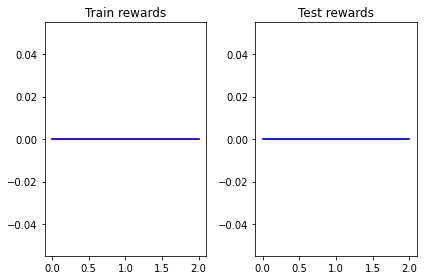

In [16]:
fig, axs = plt.subplots(1, 2)

axs[0].title.set_text('Train rewards')
axs[0].plot(train_rewards, color="red")
axs[0].plot(np.zeros_like(train_rewards), color="blue")

axs[1].title.set_text('Test rewards')
axs[1].plot(test_rewards, color="green")
axs[1].plot(np.zeros_like(test_rewards), color="blue")

plt.tight_layout()
plt.show()
